In [67]:
import numpy as np
from scipy.stats import multivariate_normal

from utils import traceplot, acfplot, pairplot

# from rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock
from ipynb.fs.full.rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock

In [55]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(logpi, n_iter, x_init, step_size=1, **kwargs):
    burn_in = 5000
    learning_rate = 0.01
    target_acceptance = 0.234

    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(burn_in):
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y


        acceptance_prob = min(1, np.exp(log_acceptance))
        step_size = np.exp(np.log(step_size) + learning_rate * (acceptance_prob - target_acceptance))

    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

Acceptance rate: 0.26196


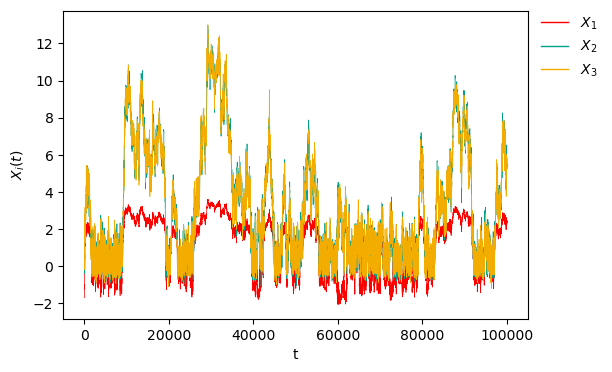

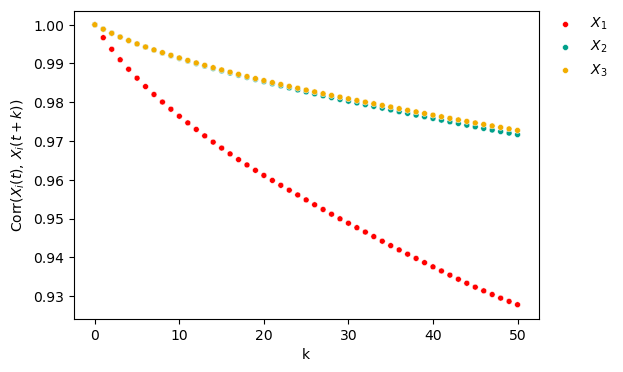

In [66]:
samples, accept_rate = RWM(
    logpi=logpi_rosenbrock,
    n_iter=100000,
    x_init=[0, 0, 0],
    n1=2,
    n2=2
)

print(f'Acceptance rate: {accept_rate}')
traceplot(samples)
acfplot(samples)

In [71]:
def logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (np.abs(x - mu) / alpha)**beta

def first_logpi_gnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - (beta / alpha**beta) * np.abs(diff)**(beta-1) * np.sign(diff)

def second_logpi_gnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - ((beta * (beta-1)) / alpha**beta) * np.abs(diff)**(beta-2)

def third_logpi_gnd(x, mu=1, alpha=1, beta=2):
    diff = x - mu
    return - ((beta * (beta-1) * (beta-2)) / alpha**beta) * np.abs(diff)**(beta-3) * np.sign(diff)

In [73]:
def SMMALA_proposal(x, partial_logpi_x, A_x, step_size, method):
    z = step_size * np.random.normal(size=x.shape[0]) 

    L_x = np.linalg.cholesky(project_to_psd(A_x, method))

    return x + (1/2) * (step_size**2) * A_x @ partial_logpi_x + L_x @ z


def SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size, method):
    mean_xy = x + (1/2) * (step_size**2) * A_x @ partial_logpi_x
    mean_yx = y + (1/2) * (step_size**2) * A_y @ partial_logpi_y

    cov_xy = (step_size**2) * A_x
    cov_yx = (step_size**2) * A_y

    log_xy = multivariate_normal.logpdf(y, mean=mean_xy, cov=project_to_psd(cov_xy, method))
    log_yx = multivariate_normal.logpdf(x, mean=mean_yx, cov=project_to_psd(cov_yx, method))
    
    return log_yx - log_xy


def SMMALA(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, method='clip', **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = np.linalg.inv(-H_x)

        # Proposal state
        y = SMMALA_proposal(x, partial_logpi_x, A_x, step_size, method)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = np.linalg.inv(-H_y)

        # Log SMMALA acceptance rate
        log_acceptance = logpi_y - logpi_x + SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size, method)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate


samples, accept_rate = SMMALA(
    logpi=logpi_gnd,
    partial_logpi=first_logpi_gnd,
    hessian_logpi=second_logpi_gnd,
    n_iter=1000,
    x_init=[0],
    step_size=0.5,
)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [ ]:
from src.dist.generalised_normal import SmoothedGeneralNormal
from src.dist.rosenbrock import Rosenbrock
from src.mcmc.rwm import RWM
from src.mcmc.mala import MALA

In [76]:
target = SmoothedGeneralNormal()

0.544


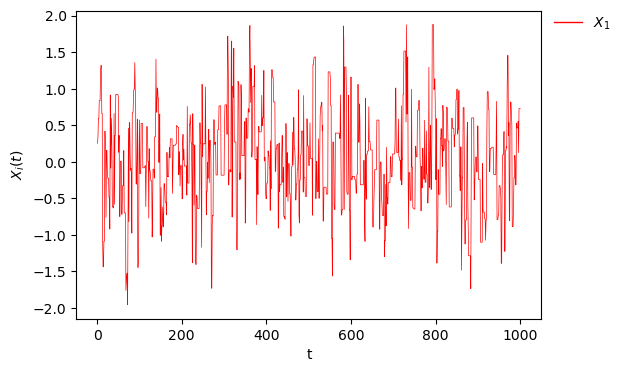

In [80]:
samples, accept_rate = RWM(target, 1000, x_init=[0], step_size=1.2)

print(accept_rate)
traceplot(samples)

In [83]:
samples, accept_rate = MALA(target, 1000, x_init=[0], step_size=1.2)

print(accept_rate)
traceplot(samples)

AttributeError: 'SmoothedGeneralNormal' object has no attribute 'partial_logpi'